# First Modeling

Here I'll take my work from the two previous notebooks, and I'll try some simple modeling

I'm going to try 3 different styles of starter models:
 - Regression
 - Binary classification
 - Tertiary classification

In [14]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import wikipedia
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix

### Tidying up

Let's take our data from the 'games_with_plots.csv' file that we exported from the [wikiscraping](./02_wikiscraping.ipynb) notebook

In [2]:
games_with_plots = pd.read_csv('../data/games_with_plots.csv')
games_with_plots.shape

(4196, 19)

Grab just the columns we're interested in for now

In [3]:
important_columns = ['game', 'console', 'publisher', 'developer',
                     'critic_score', 'release_date', 'plots']
gdf = games_with_plots[important_columns]

Put a little text cleaner here for now, i'm not really sure if this is necessary but w/e 

\***move to src folder soon**\*

In [4]:
def clean_text(text):
    import string
    words = [''.join(ch for ch in s if ch not in string.punctuation) for s in text.split()]
    return ' '.join(words).lower()

Let's do some minor data cleaning

In [5]:
gdf.plots = gdf.plots.apply(clean_text)
gdf.release_date = pd.to_datetime(gdf.release_date, errors='coerce')
gdf.critic_score = gdf.critic_score.astype(float)
gdf.sample(5)

,game,console,publisher,developer,critic_score,release_date,plots
2317,X-Men: The Official Game,X360,Activision,"Z-Axis, Ltd.",4.9,2006-05-16,during a session in the xavier institutes dang...
2085,Peter Jackson's King Kong: The Official Game o...,GC,Ubisoft,Ubisoft Montpellier,8.1,2005-11-21,in 1933 film director carl denham jack black h...
1646,Zack & Wiki: Quest for Barbaros' Treasure,Wii,Capcom,Capcom,8.7,2007-10-23,while flying to the sea rabbits hideout zack a...
943,Rocksmith 2014,X360,Ubisoft,Ubisoft San Francisco,8.4,2013-10-22,rocksmith 2014 recommends the use of the hercu...
1850,Dead Rising 2: Off the Record,PS3,Capcom,Blue Castle Games,7.1,2011-10-11,the entire game is a what if scenario where fr...


Looking pretty clean, let's go ahead

### Modeling

We'll get our main data split up here

In [7]:
y = gdf[['critic_score']]
X = gdf[['developer', 'plots']]
X_train, X_test, y_train, y_test = train_test_split(X, y)

Let's vectorize our plots for our first simple model, and let's just start with 1000 features

In [21]:
tf = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tf = tf.fit_transform(X_train.plots)
X_test_tf = tf.transform(X_test.plots)

First model we'll try is just a vanilla Random Forest Regressor

In [22]:
rf = RandomForestRegressor()
rf.fit(X_train_tf, y_train.values.ravel())

RandomForestRegressor()

In [23]:
rf.score(X_test_tf, y_test.values.ravel())

0.3136357461345066

Looks like an FSM score to me....

## New idea: Binning our target

I'm interested in trying to make a simpler model by binning our target variable. First I would like to try just two classifications of critical success, successful or unsuccessful

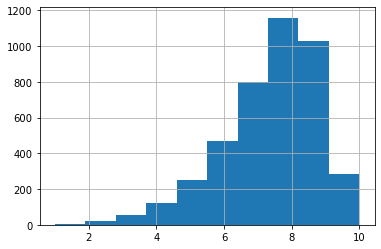

In [24]:
gdf.critic_score.hist();

This left-skewed distribution is typical of reviews, so maybe we should make our first split at 7

In [8]:
gdf['success'] = (gdf['critic_score'] > 7).astype(int)
gdf.head()

,game,console,publisher,developer,critic_score,release_date,plots,success
0,Wii Sports,Wii,Nintendo,Nintendo EAD,7.7,2006-11-19,wii sports consists of five separate sports ga...,1
1,Super Mario Bros.,NES,Nintendo,Nintendo EAD,10.0,1985-10-18,in the fantasy setting of the mushroom kingdom...,1
2,Mario Kart Wii,Wii,Nintendo,Nintendo EAD,8.2,2008-04-27,mario kart wii is a kart racing game featuring...,1
3,Minecraft,PC,Mojang,Mojang AB,10.0,2010-05-10,minecraft is a 3d sandbox game that has no spe...,1
4,Wii Sports Resort,Wii,Nintendo,Nintendo EAD,8.0,2009-07-26,wii sports resort is a sports video game set i...,1


In [9]:
gdf.success.value_counts()

1    2636
0    1560
Name: success, dtype: int64

### Modeling again

Let's get going with a classifier model

I'll use SVM as it tends to work well for these text-based things

In [29]:
y = gdf[['success']]
X = gdf[['developer', 'plots']]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [30]:
tf = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tf = tf.fit_transform(X_train.plots)
X_test_tf = tf.transform(X_test.plots)

In [31]:
svm = SGDClassifier()
svm.fit(X_train_tf, y_train.values.ravel())

SGDClassifier()

Let's see how our accuracy for our base classifier model does

In [32]:
svm.score(X_test_tf, y_test)

0.6978074356530028

In [33]:
confusion_matrix(y_test, svm.predict(X_test_tf))

array([[551, 134],
       [183, 181]], dtype=int64)

**Not a bad place to start**,  but not great either

Last thing I want to try is a tertiary classification

Let's make a function to divide up the scores into 3 bins

In [6]:
def success(value):
    '''
    function for binning the critic scores
    '''
    
    if value > 7:
        if value > 8:
            return 2
        return 1
    return 0

Apply our function and check the class sizes

In [7]:
gdf['success'] = gdf.critic_score.apply(success)

In [8]:
gdf.success.value_counts()

0    1560
2    1447
1    1189
Name: success, dtype: int64

I'm just going to do the same things I did for the binary here

In [10]:
y = gdf[['success']]
X = gdf[['developer', 'plots']]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
tf = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tf = tf.fit_transform(X_train.plots)
X_test_tf = tf.transform(X_test.plots)

I don't know if this is a good classifier for this but we'll try it

In [12]:
svm = SGDClassifier()
svm.fit(X_train_tf, y_train.values.ravel())

SGDClassifier()

In [13]:
svm.score(X_test_tf, y_test)

0.5185891325071497

Alright I need to do more testing here, and actually decide on what type of thing I'm doing.....

In [17]:
rf = RandomForestClassifier()
rf.fit(X_train_tf, y_train.values.ravel())

RandomForestClassifier()

In [18]:
rf.score(X_test_tf, y_test)

0.567206863679695

**bang** I think I'm going to stick with the tertiary classification for now.

I will also need to explore stemming/lemmatizing words to clean this stuff up a little bit.